In [41]:
import os
import json
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
import scipy
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeRegressor
import math
import warnings
warnings.filterwarnings("ignore")

Individual project of Ekaterina Chebeneva

## Introduction
### 1 Feature and data explanation

https://www.kaggle.com/spscientist/students-performance-in-exams/home

This data set consists of the marks secured by the students in various subjects.

Aim of the project is to understand the influence of various factors on the students performance and to predict the average score in three subjects

#### Data description

- gender: male and female
- race/ethnicity
- parental level of education
- lunch: lunch level, Standard or Free/Reduced
- test preparation course: presumably, "none" means that the student did not attend preparatory courses, and "Completed" means that they completed it.
- math score
- reading score
- writing score
- **avg_score: target feature, which is the average score for three subject**

In [67]:
df = pd.read_csv('Downloads/StudentsPerformance.csv')
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [68]:
df['avg_score'] = (df['math score'] + df['reading score'] + df['writing score']) / 3
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,avg_score
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667
1,female,group C,some college,standard,completed,69,90,88,82.333333
2,female,group B,master's degree,standard,none,90,95,93,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333
4,male,group C,some college,standard,none,76,78,75,76.333333


In [4]:
df.shape

(1000, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
gender                         1000 non-null object
race/ethnicity                 1000 non-null object
parental level of education    1000 non-null object
lunch                          1000 non-null object
test preparation course        1000 non-null object
math score                     1000 non-null int64
reading score                  1000 non-null int64
writing score                  1000 non-null int64
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [6]:
df.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


In [12]:
pd.unique(df['test preparation course'])

array(['none', 'completed'], dtype=object)

In [11]:
pd.unique(df['parental level of education'])

array(["bachelor's degree", 'some college', "master's degree",
       "associate's degree", 'high school', 'some high school'],
      dtype=object)

In [7]:
df.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

As seen above, there are no null values in this datafram

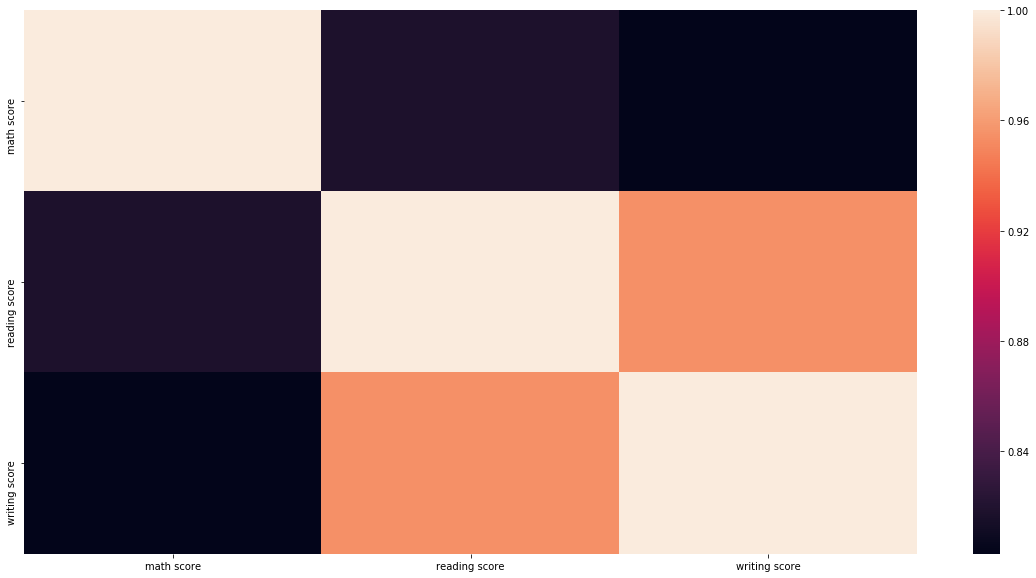

In [22]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr())

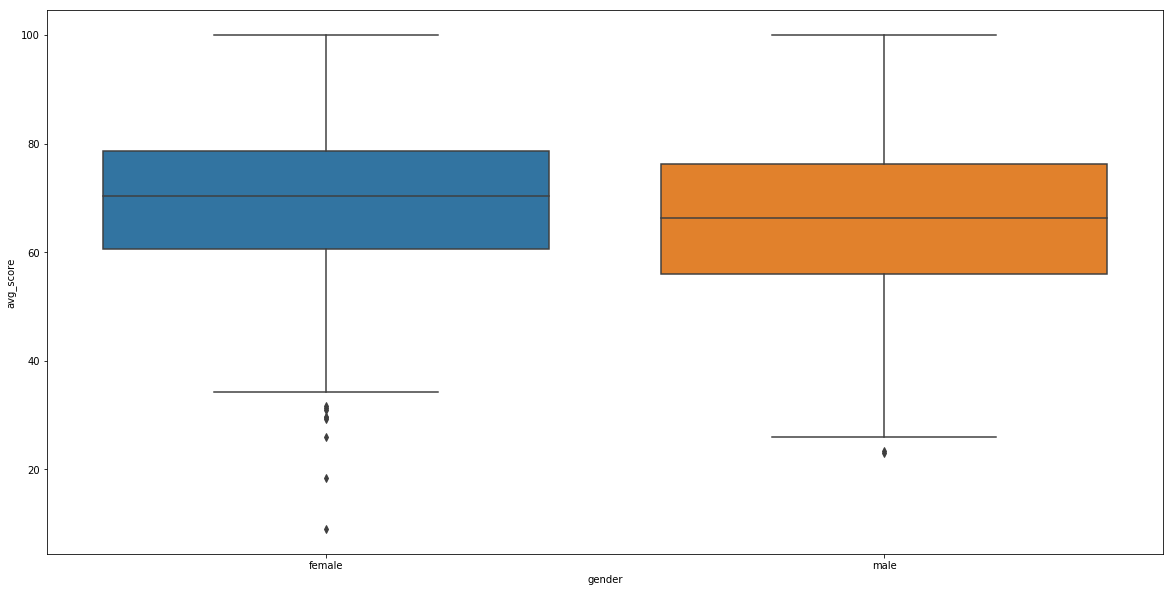

In [29]:
plt.figure(figsize=(20, 10))
sns.boxplot(x='gender', y='avg_score', data=df)

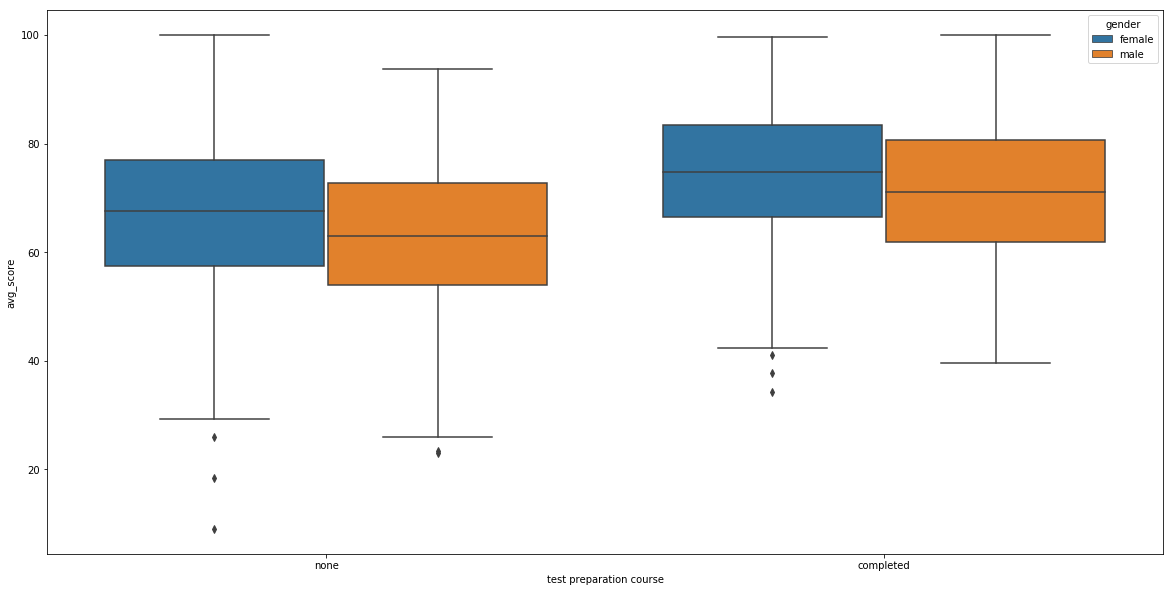

In [32]:
plt.figure(figsize=(20, 10))
sns.boxplot(y='avg_score', x='test preparation course', hue='gender', data=df)

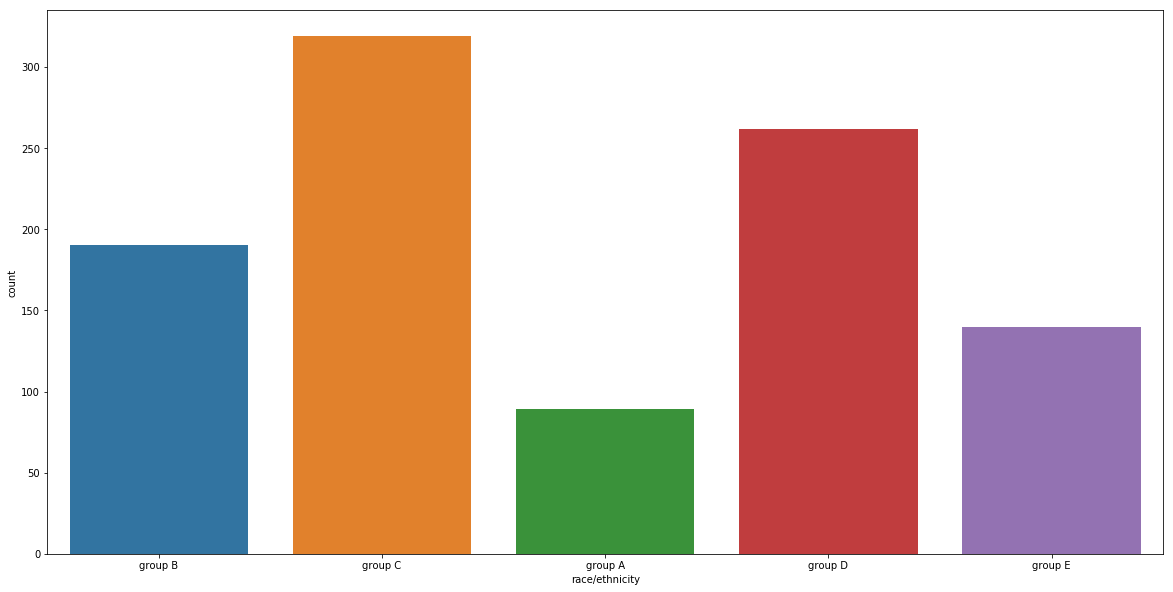

In [39]:
plt.figure(figsize=(20, 10))
sns.countplot(x='race/ethnicity', data=df)

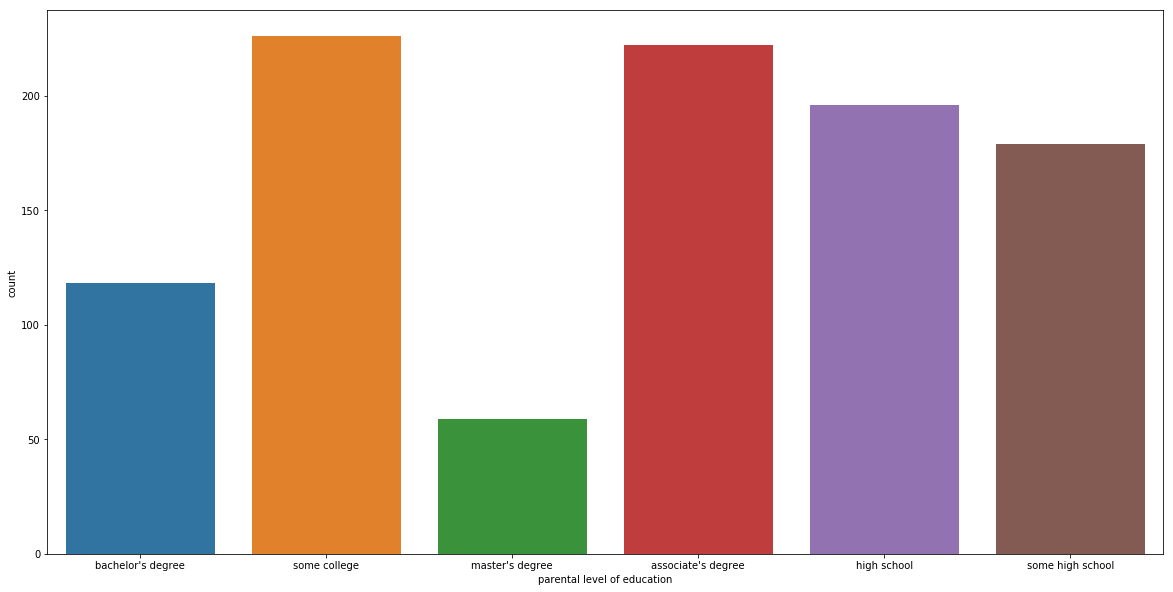

In [43]:
plt.figure(figsize=(20, 10))
sns.countplot(x='parental level of education', data=df)

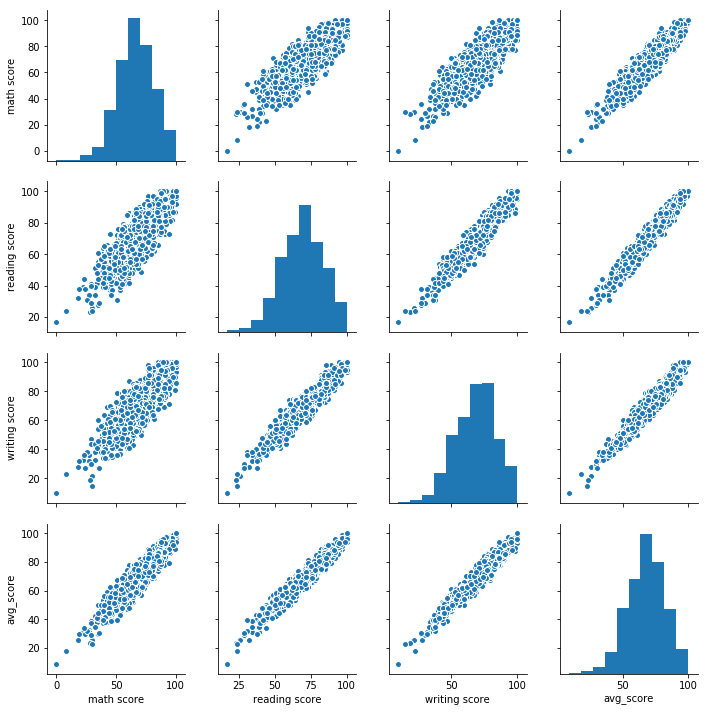

In [50]:
sns.pairplot(df)

In [51]:
pd.unique(df['parental level of education'])

array(["bachelor's degree", 'some college', "master's degree",
       "associate's degree", 'high school', 'some high school'],
      dtype=object)

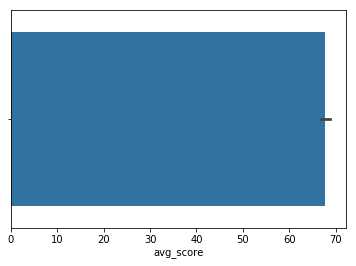

In [57]:
sns.barplot(x='avg_score', hue='parental level of education', data=df)

In [58]:
# Function that prints summary statistics of column given in parameters
def summary_statistics(col, df):
    print('Mean: {}'.format(df[col].mean()))
    print('Max: {}'.format(df[col].max()))
    print('Min: {}'.format(df[col].min()))
    print('Median: {}'.format(df[col].median()))
    print()
    
    # Number of students with maximum and minimum score
    max_score = df[col].max()
    min_score = df[col].min()
    print("Number of students who scored maximum score: {}".format(df[col][df[col]==max_score].count()))
    print("Number of students who scored minimum score: {}".format(df[col][df[col]==min_score].count()))
    print()
    
    # Students close to mean i.e. Students that have scores equal to floor(mean score) or ceiling(mean score)
    near_mean_floor = math.floor(df[col].mean())
    near_mean_ceil = math.ceil(df[col].mean())
    near_mean_tot = df[col][df[col]==near_mean_floor].count() + df[col][df[col]==near_mean_ceil].count()
    print("Number of students close to mean score: {}".format(near_mean_tot))
    print()
    
    # Students that have 50th percentile
    print("Number of students at median score: {}".format(df[col][df[col]==df[col].median()].count()))
    
    # Students with 25th percentile and 75th percentile scores
    print("Number of students at 25th percentile: {}".format(df[col][df[col]==df[col].quantile(0.25)].count()))
    print("Number of students at 75th percentile: {}".format(df[col][df[col]==df[col].quantile(0.75)].count()))

In [62]:
summary_statistics("math score", df)

Mean: 66.089
Max: 100
Min: 0
Median: 66.0

Number of students who scored maximum score: 7
Number of students who scored minimum score: 1

Number of students close to mean score: 50

Number of students at median score: 24
Number of students at 25th percentile: 18
Number of students at 75th percentile: 24


In [63]:
summary_statistics("reading score", df)

Mean: 69.169
Max: 100
Min: 17
Median: 70.0

Number of students who scored maximum score: 17
Number of students who scored minimum score: 1

Number of students close to mean score: 41

Number of students at median score: 26
Number of students at 25th percentile: 17
Number of students at 75th percentile: 19


In [64]:
summary_statistics("writing score", df)

Mean: 68.054
Max: 100
Min: 10
Median: 69.0

Number of students who scored maximum score: 14
Number of students who scored minimum score: 1

Number of students close to mean score: 54

Number of students at median score: 23
Number of students at 25th percentile: 0
Number of students at 75th percentile: 19


**Does completing course really affects the score?**

In [68]:
#Students that have more than median marks in 

# Maths
print("Maths")
df_top_math = df[df["math score"] > df["math score"].median()]
print(df_top_math["test preparation course"].value_counts())
print()

# Reading
print("Reading")
df_top_read = df[df["reading score"] > df["reading score"].median()]
print(df_top_read["test preparation course"].value_counts())
print()

# Writing
print("Writing")
df_top_writ = df[df["writing score"] > df["writing score"].median()]
print(df_top_writ["test preparation course"].value_counts())
print()

print("Average score")
df_top_writ = df[df["avg_score"] > df["avg_score"].median()]
print(df_top_writ["test preparation course"].value_counts())
print()

Maths
none         282
completed    211
Name: test preparation course, dtype: int64

Reading
none         263
completed    224
Name: test preparation course, dtype: int64

Writing
none         251
completed    238
Name: test preparation course, dtype: int64

Average score
none         267
completed    231
Name: test preparation course, dtype: int64



We can see that there is almost a ratio of 1:1 for students who have completed the course and students who have not completed the course (for more than median score). So, we can set a hypothesis like Possibility of scoring more than median marks in test remains unchanged after completing.
But this cannot be stated as a final conclusion.

In [71]:
#Students that have less than or equal to median marks in  

# Maths
print("Maths")
df_bot_math = df[df["math score"] <= df["math score"].median()]
print(df_bot_math["test preparation course"].value_counts())
print()

# Reading
print("Reading")
df_bot_read = df[df["reading score"] <= df["reading score"].median()]
print(df_bot_read["test preparation course"].value_counts())
print()

# Writing
print("Writing")
df_bot_writ = df[df["writing score"] <= df["writing score"].median()]
print(df_bot_writ["test preparation course"].value_counts())
print()

print("Average score")
df_top_writ = df[df["avg_score"] <= df["avg_score"].median()]
print(df_top_writ["test preparation course"].value_counts())
print()

Maths
none         360
completed    147
Name: test preparation course, dtype: int64

Reading
none         379
completed    134
Name: test preparation course, dtype: int64

Writing
none         391
completed    120
Name: test preparation course, dtype: int64

Average score
none         375
completed    127
Name: test preparation course, dtype: int64



For the students that have less than or equal to median marks the hypothesis assumed above has been proven wrong. As, there is a ratio of 2:1 for the students that have not completed the course to the students who have completed the course. So our new hypothesis could be that
You are twice as likely to score less than median marks if you don't complete the test preperation course
But this too, cannot be stated as final conclusion.

In [6]:
def graphs(score_type, suptitle, groupbyterm, kind):
    nrows = 2
    ncols = 3
    inches = 5
    df_female = df[df['gender'] == 'female']
    df_male = df[df['gender'] == 'male']
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*inches,nrows*inches))
    fig.suptitle(suptitle)
    temp = df[groupbyterm].value_counts().rename("")
    temp.plot.pie(ax=axes[0,0], title="Students Overall", autopct="%.2f", legend=False)
    temp = df_female[groupbyterm].value_counts().rename("")
    temp.plot.pie(ax=axes[0,1], title="Female", autopct="%.2f", legend=False)
    temp = df_male[groupbyterm].value_counts().rename("")
    temp.plot.pie(ax=axes[0,2], title="Male", autopct="%.2f", legend=False)
    pd.concat([
        df_female.groupby(groupbyterm)[score_type].mean().rename("Female"),
        df_male.groupby(groupbyterm)[score_type].mean().rename("Male")], axis=1).plot(kind="bar", ax=axes[1,0], legend=True)
    axes[1,0].set_xlabel("")
    axes[1,0].legend([x.get_text().capitalize() for x in axes[1,0].legend().get_texts()])
    axes[1,0].set_xticklabels([x.get_text().capitalize() for x in axes[1,0].get_xticklabels()])
    df_female.groupby(groupbyterm)[score_type].plot(kind=kind, ax=axes[1,1], legend=True, alpha=0.8, histtype="step")
    axes[1,1].set_xlabel("Female Scores")
    axes[1,1].set_ylabel("")
    axes[1,1].set_xticks(np.arange(0, 101, step=20))
    axes[1,1].set_yticks(np.arange(0, 101, step=20))
    axes[1,1].legend([x.get_text().capitalize() for x in axes[1,1].legend().get_texts()])
    df_male.groupby(groupbyterm)[score_type].plot(kind=kind, ax=axes[1,2], legend=True, alpha=0.8, histtype="step")
    axes[1,2].set_xlabel("Male Scores")
    axes[1,2].set_ylabel("")
    axes[1,2].set_xticks(np.arange(0, 101, step=20))
    axes[1,2].set_yticks(np.arange(0, 101, step=20))
    axes[1,2].legend([x.get_text().capitalize() for x in axes[1,2].legend().get_texts()])
    return fig, axes

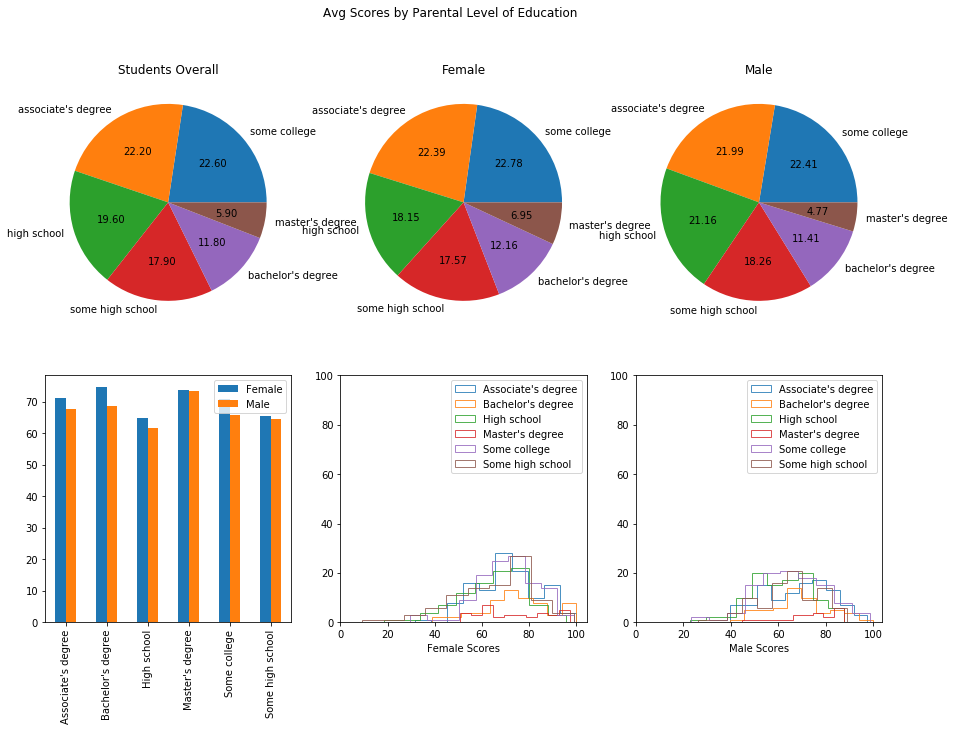

In [11]:
fig, axes = graphs("avg_score","Avg Scores by Parental Level of Education", "parental level of education", "hist")

Very few parents hold a Bachelor's degree; fewer still, hold Master's degree. Because we have fewer samples of parents holding math degrees, it stands to show that the scores for these students will be higher on average, as opposed to the other degrees. But looking at the more populated degrees, their scores also show variations, albeit not a lot, but variations nevertheless.

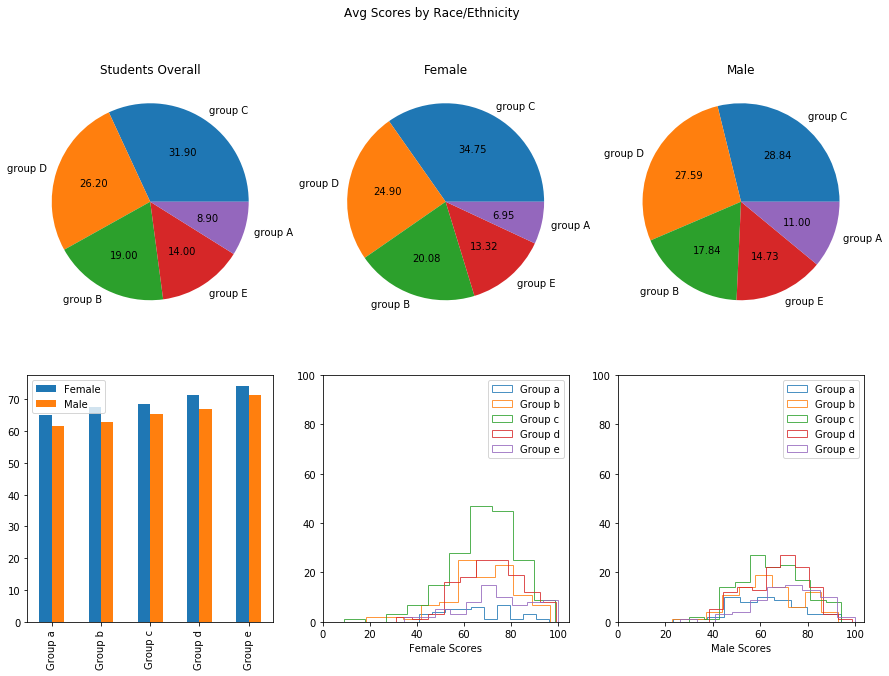

In [10]:
fig, axes = graphs("avg_score","Avg Scores by Race/Ethnicity", "race/ethnicity", "hist")

Shortest population in Race/Ethnic group A. And in terms of performance, they are still at the lowest on average. Most dense population in Race/Ethnic group C. In terms of performance, they're average.

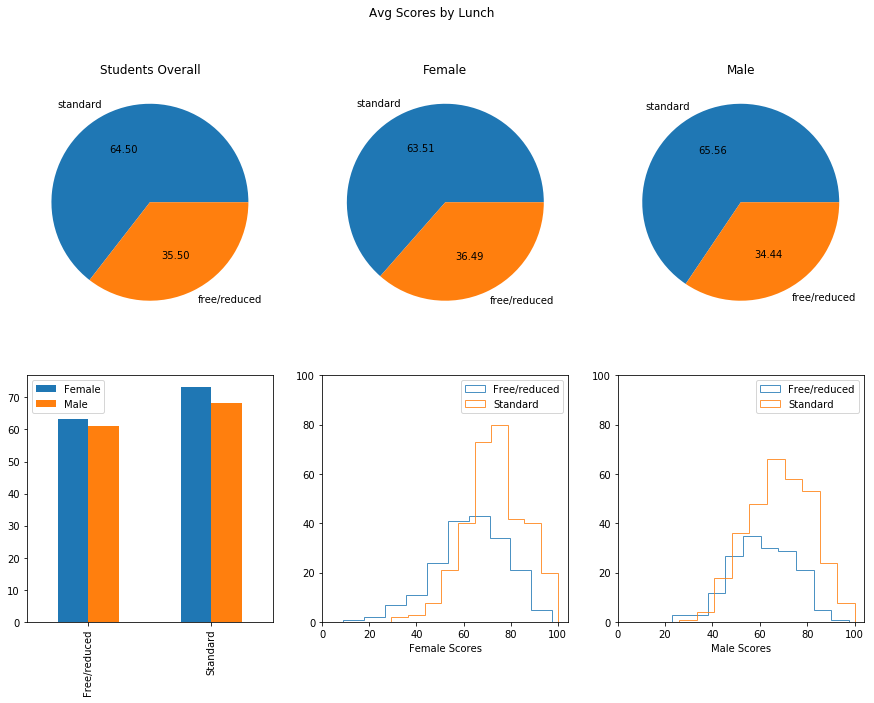

In [12]:
fig, axes = graphs("avg_score","Avg Scores by Lunch", "lunch", "hist")

Following the averages, boys still outperform the girls at math regardless of lunch. Almost two-thirds of the students had a standard lunch. It's good to know that these students didn't sacrifice their stomachs for scores.


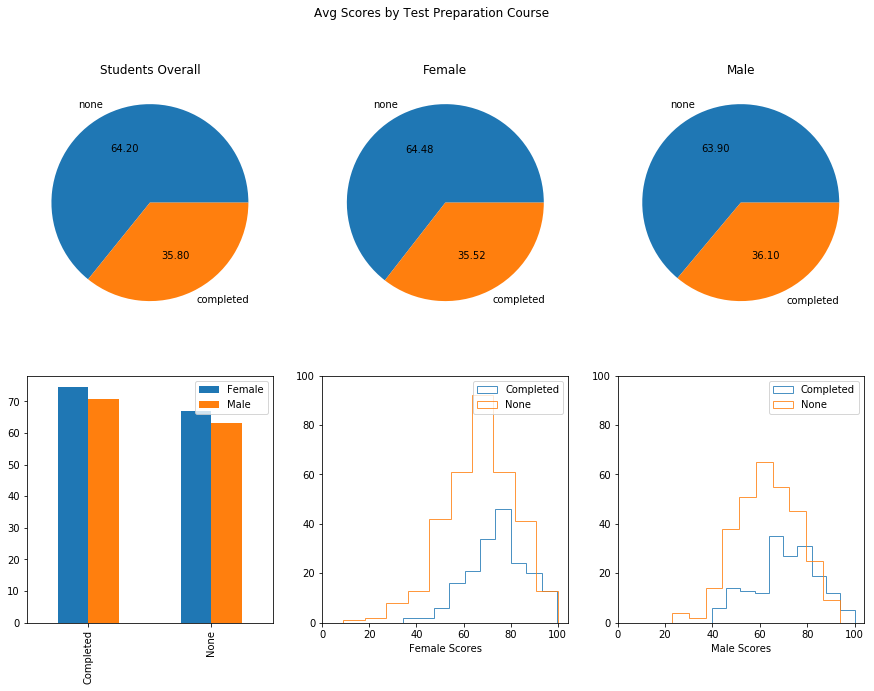

In [14]:
fig, axes = graphs("avg_score","Avg Scores by Test Preparation Course", "test preparation course", "hist")

Going off of the numbers in the graphs, Only a third of the students are taking these courses seriously. And the ones that did take the courses aren't having a significant advantage at scores. So should the Preparatory courses be cancelled? Looking at the smaller bounds, Students that took the preparatory course have higher baselines than the ones that didn't. So it's probably good to keep them going.

**Distribution of student scores**

All the scores are approximately normally distributed. Q-Q plots show skewness in both directions, indicating deviation from normal distribution in those regions.
Joint distributions show strong correlation between test scores among different subjects which is not surprising.

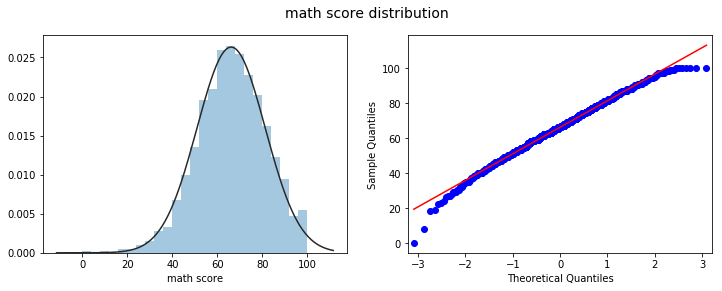

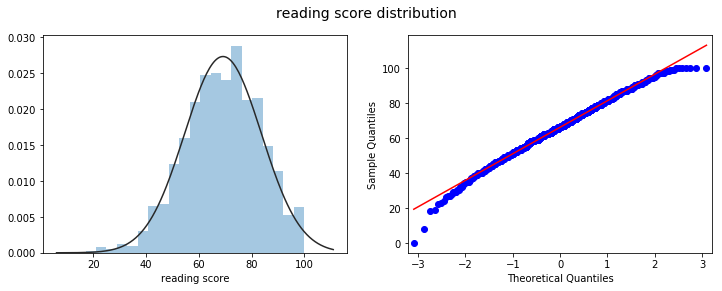

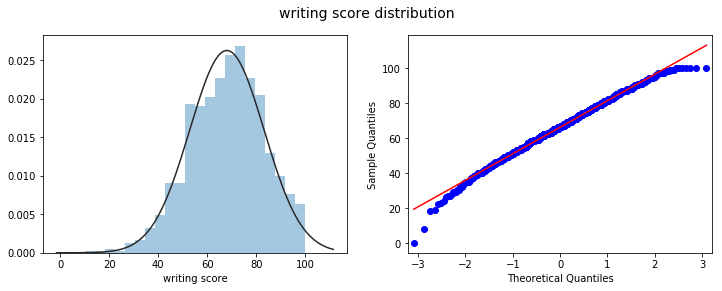

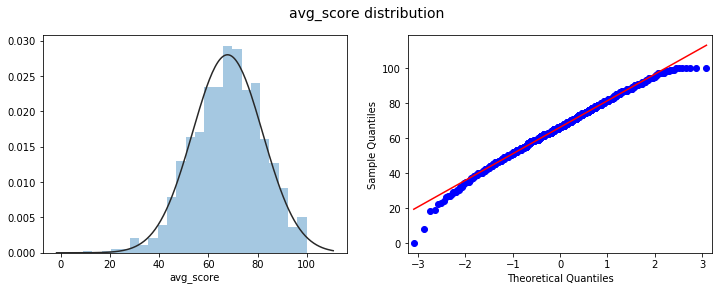

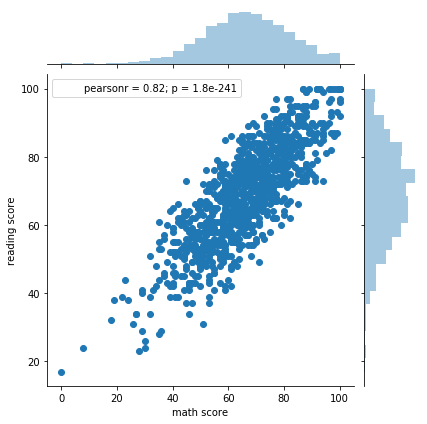

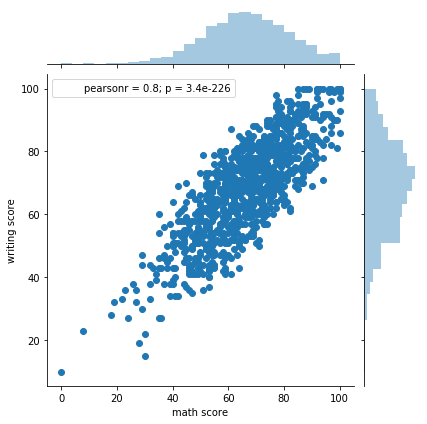

In [24]:
score_cols = ['math score', 'reading score','writing score', 'avg_score']
from scipy.stats import norm


def Plot_Dist(df, col):
    fig,axarr = plt.subplots(1,2,figsize=(12,4))
    # plot distribution
    sns.distplot(df[col], fit=norm, kde=False, ax=axarr[0])
    #Q-Q plot
    from statsmodels.graphics.gofplots import qqplot
    qqplot(df['math score'],line='s', ax=axarr[1])
    fig.suptitle(col+' distribution', fontsize=14)
    plt.show()

Plot_Dist(df,col='math score')
Plot_Dist(df,col='reading score')
Plot_Dist(df,col='writing score')
Plot_Dist(df,col='avg_score')


ax1=sns.jointplot(x="math score", y="reading score", data=df)
plt.show()

ax2=sns.jointplot(x="math score", y="writing score", data=df)
plt.show()

**Variation of Scores with Gender of the student**

Female students beat male counter parts in reading and writing. In math, boys on an average do better than girls.

In [28]:
def Plot_Set(df, xcol, ycols):
    df = df.sort_values(by=xcol)
    fig,axarr = plt.subplots(1, 4,figsize=(12,5))
    for id,ycol in enumerate(ycols):
        medians = df.groupby([xcol])[ycol].median().values
        median_labels = [str(np.round(s, 2)) for s in medians]
        pos = range(len(medians))
        sns.boxplot(x=xcol, y=ycol, data=df, width=0.5, palette='Set3', ax=axarr[id], linewidth=0.5)
        for tick,label in zip(pos,axarr[id].get_xticklabels()):
            axarr[id].text(pos[tick], medians[tick] + 0.5, median_labels[tick], horizontalalignment='center', size='medium', color='k', weight='semibold')
        axarr[id].set_ylim([0,105])
        plt.setp(axarr[id].get_xticklabels(), rotation=25,ha='right')
    plt.tight_layout()
    plt.show()

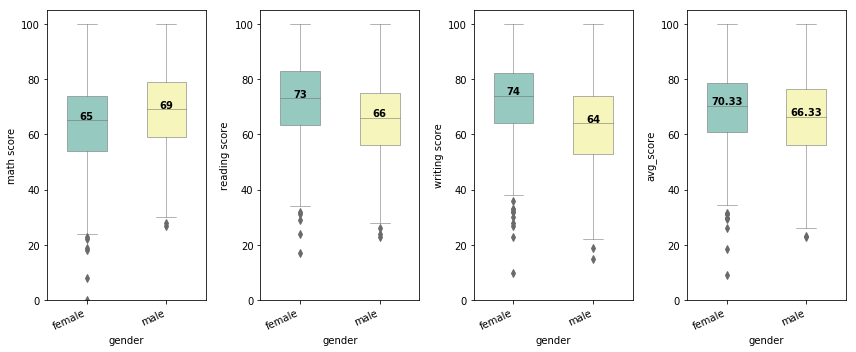

In [29]:
Plot_Set(df, xcol='gender', ycols=['math score','reading score','writing score', 'avg_score'])

**Variation of Scores with race/ethnicity**

Race has a significant influence on test scores. For all subjects, students in group E perform better than students from other ethnicity.

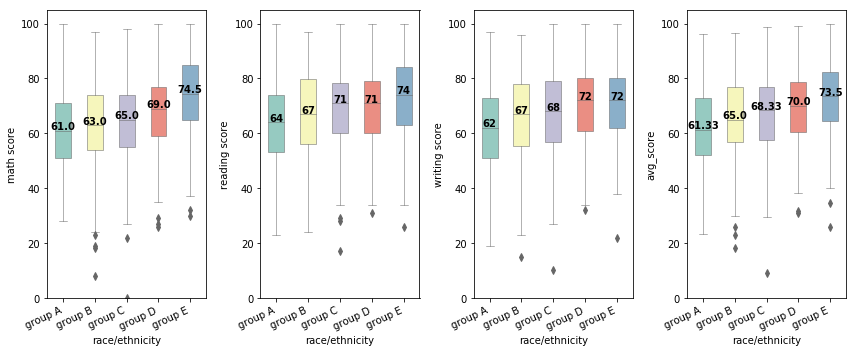

In [30]:
Plot_Set(df,xcol='race/ethnicity',ycols=['math score','reading score','writing score', 'avg_score'])

**Variation of Scores with parental level of education**

Education level of parents has a direct impact on the test scores. Higher the education level of the parent, higher the student scores.

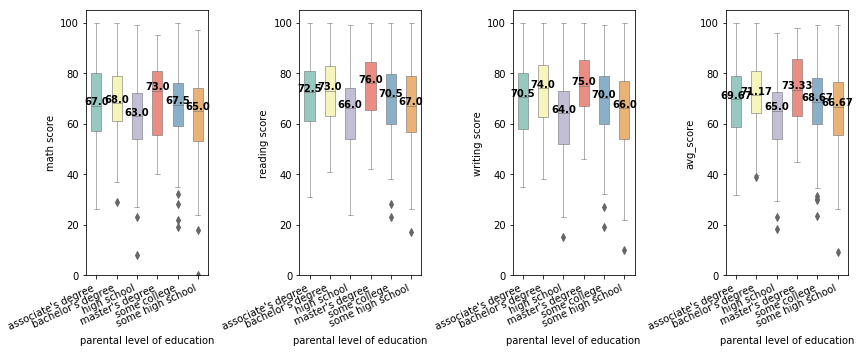

In [32]:
Plot_Set(df,xcol='parental level of education',ycols=['math score','reading score','writing score', 'avg_score'])

**Variation of Scores with lunch type**

Whether the student gets the standard lunch or free/reduced lunch has an impact on the scores. It is evident students from lower income families on an average have 5-10 points lower scores than those who can afford standard lunches.

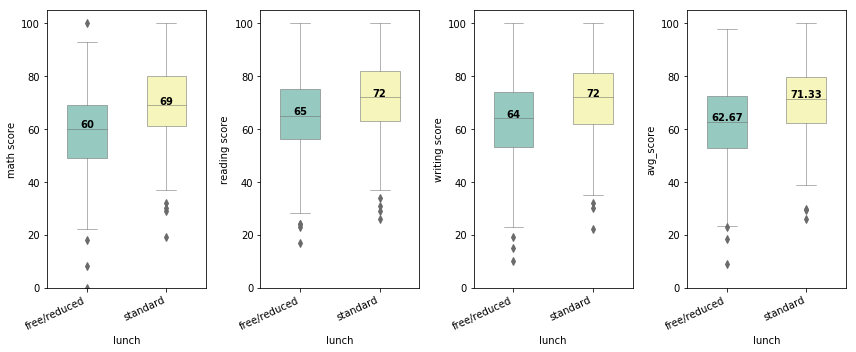

In [33]:
Plot_Set(df,xcol='lunch',ycols=['math score','reading score','writing score', 'avg_score'])

# Prediction 

MAE and RMSE are the two most popular metrics for continuous variables. Let’s start with the more popular one.

It is easy to interpret MAE because it directly takes the average of offsets whereas RMSE penalizes the higher difference more than MAE. Therefore, I chose mse as the metric


Decision tree selected as model for prediction.

Tree classification techniques, when they "work" and produce accurate predictions or predicted classifications based on few logical if-then conditions, have a number of advantages over many of those alternative techniques. Simplicity of results. In most cases, the interpretation of results summarized in a tree is very simple. This simplicity is useful not only for purposes of rapid classification of new observations (it is much easier to evaluate just one or two logical conditions, than to compute classification scores for each possible group, or predicted values, based on all predictors and using possibly some complex nonlinear model equations), but can also often yield a much simpler "model" for explaining why observations are classified or predicted in a particular manner (e.g., when analyzing business problems, it is much easier to present a few simple if-then statements to management, than some elaborate equations).

For data preprocessing is used one hot encoding for categorical features.

In [36]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,avg_score
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667
1,female,group C,some college,standard,completed,69,90,88,82.333333
2,female,group B,master's degree,standard,none,90,95,93,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333
4,male,group C,some college,standard,none,76,78,75,76.333333


In [59]:
df = pd.concat([df, pd.get_dummies(df.gender, prefix='gender_')], axis=1)
df = pd.concat([df, pd.get_dummies(df['race/ethnicity'], prefix='race_')], axis=1)
df = pd.concat([df, pd.get_dummies(df['parental level of education'], prefix='edu_')], axis=1)
df = pd.concat([df, pd.get_dummies(df['lunch'], prefix='lunch_')], axis=1)
df = pd.concat([df, pd.get_dummies(df['test preparation course'], prefix='course_')], axis=1)

In [60]:
df.drop(columns=['gender', 'race/ethnicity','parental level of education', 'lunch', 'test preparation course'], inplace=True)

In [63]:
target = df.avg_score
df.drop(columns=['math score', 'reading score', 'writing score', 'avg_score'], inplace=True)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.33, random_state=17)

In [65]:
dtr = DecisionTreeRegressor(max_depth=4, random_state=17)

cross_val_score(dtr, df, target, cv=10, scoring='neg_mean_squared_error')

array([ -9.77716057, -10.11749012,  -8.89460104,  -8.98429485,
        -9.01486071, -10.4526375 ,  -9.72163352,  -9.67709554,
       -10.58875764,  -8.10790442])

In [66]:
dtr = DecisionTreeRegressor(max_depth=4, random_state=17)

dtr.fit(X_train, y_train)

y_pred = dtr.predict(X_test)
mean_absolute_error(y_test, y_pred)

2.4446301839896276